In [33]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan

import pandas as pd
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [7]:

import warnings
warnings.filterwarnings("ignore")

# Elasticsearch connection settings
ES_URL = 'https://elasticsearch:31001'  # Elasticsearch host

# Initialize Elasticsearch client
es = Elasticsearch([ES_URL], basic_auth=('elastic', "cloudcomp"), verify_certs=False)

print(es.ping())

True


In [41]:
def get_full_data(index_name):
    # Define search query (optional, can be empty to retrieve all documents)
    query = {
        "query": {
            "match_all": {}
        }
    }

    # Start scrolling through documents
    scroll = scan(client=es, index=index_name, query=query, scroll='5m')

    data = []

    # Iterate over search results
    for i, result in enumerate(scroll):
        # Access document fields
        doc_id = result['_id']
        doc_source = result['_source']
        data.append(doc_source)

    return data


In [45]:
CRASHES_IDX = 'crashes'  # Elasticsearch index name

crash_data = get_full_data(CRASHES_IDX)

In [46]:
# Filter out entries without 'crash_date' field and 'severity' field
data = [entry for entry in crash_data if 'crash_date' in entry and 'severity' in entry]

# Convert 'crash_date' strings to datetime objects and extract year-month
for entry in data:
    entry['crash_date'] = datetime.strptime(entry['crash_date'][:10], "%Y-%m-%d").strftime("%Y-%m")

# Convert data to DataFrame
df = pd.DataFrame(data)

# Group by 'crash_date' and sum up 'severity'
crash_severity = df.groupby('crash_date')['severity'].sum().reset_index()

del data

print(crash_severity)

# Convert 'Date' strings to datetime objects and extract year-month
# for entry in get_full_data(WEATHER_PAST_IDX):
#     entry['Date'] = datetime.strptime(entry['Date'], "%d/%m/%Y").strftime("%Y-%m")


    crash_date  severity
0      2010-01       176
1      2010-02       198
2      2010-03       215
3      2010-04       150
4      2010-05       155
..         ...       ...
127    2020-08       171
128    2020-09       135
129    2020-10       264
130    2020-11       207
131    2020-12        25

[132 rows x 2 columns]


In [47]:
WEATHER_PAST_IDX = 'weather_past_obs'  # Elasticsearch index name

weather_data = get_full_data(WEATHER_PAST_IDX)

In [48]:
# Filter out entries without 'Date' field and 'Min Temp' field and 'Min Humid' field
data = [entry for entry in weather_data if 'Date' in entry and 'Min Temp' in entry and 'Min Humid' in entry]

# Convert 'Date' strings to datetime objects and extract year-month
for entry in data:
    entry['Date'] = datetime.strptime(entry['Date'], "%d/%m/%Y").strftime("%Y-%m")

# Convert data to DataFrame
df = pd.DataFrame(data)

# Convert numeric columns to float
numeric_columns = ['Max Humid', 'Min Humid', 'Min Temp', 'Max Temp', 'Rain', 'Pan-Rain', 'Evapo-Rain']
df[numeric_columns] = df[numeric_columns].astype(float)

# Filter out numbers not in range (-100, 100)
for col in numeric_columns:
    df = df[(df[col] >= -100) & (df[col] <= 100)]

# Group by 'Date' and calculate averages
weather_avg = df.groupby('Date')[numeric_columns].mean().reset_index()

# free memory
del data

print(weather_avg.head())


      Date  Max Humid  Min Humid   Min Temp   Max Temp      Rain  Pan-Rain  \
0  2009-01  88.133333  40.333333  10.069444  22.243889  1.381111 -0.098889   
1  2009-02  88.366460  45.229814  10.219876  21.642857  1.366460 -0.203727   
2  2009-03  83.852459  48.786885  10.101639  19.560656  2.426230 -0.392350   
3  2009-04  94.124294  56.192090   7.068927  16.415254  2.287006 -0.613559   
4  2009-05  91.966480  60.363128   5.858659  14.125140  1.973184 -0.712849   

   Evapo-Rain  
0    5.503333  
1    3.967702  
2    2.043716  
3    2.119209  
4    1.302793  


In [49]:
merged_df = pd.merge(weather_avg, crash_severity, how='inner', left_on='Date', right_on='crash_date')
merged_df.fillna(0, inplace=True)  # Replace NaN (no y for X) with 0 severity
print(merged_df)

        Date  Max Humid  Min Humid   Min Temp   Max Temp      Rain  Pan-Rain  \
0    2010-01  88.548913  39.538043  10.128804  22.897283  0.672826  0.166304   
1    2010-02  91.422619  45.035714  11.351190  23.395238  1.898810  0.004762   
2    2010-03  89.695652  47.092391  10.518478  21.696196  2.173913 -0.214130   
3    2010-04  93.011236  56.286517   8.560112  17.986517  1.934831 -0.556742   
4    2010-05  93.236559  59.602151   4.865591  14.368817  1.503226 -0.690323   
..       ...        ...        ...        ...        ...       ...       ...   
127  2020-08  93.380019  64.431373   4.311578  11.883754  3.096359 -0.763679   
128  2020-09  90.738492  57.827620   5.879628  14.135260  2.253281 -0.696964   
129  2020-10  92.372770  58.398122   6.810986  14.964601  3.656526 -0.657277   
130  2020-11  90.135790  50.387973   9.499903  19.588070  1.267313 -0.523569   
131  2020-12  89.802412  52.235622   9.016512  18.511317  2.642486 -0.524861   

     Evapo-Rain crash_date  severity  


In [51]:

def linear_analysis(metric_key):
    X = merged_df[[metric_key]]
    y = merged_df['severity']
    # Create and fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Predict using the fitted model
    y_pred = model.predict(X)

    # Plotting
    plt.scatter(X, y, color='blue', label='Actual Data')
    plt.plot(X, y_pred, color='red', label='Linear Regression')
    plt.title(f'Linear Regression: Severity vs {metric_key}')
    plt.xlabel(metric_key)
    plt.ylabel('Severity')
    plt.legend()
    plt.grid(True)
    plt.show()

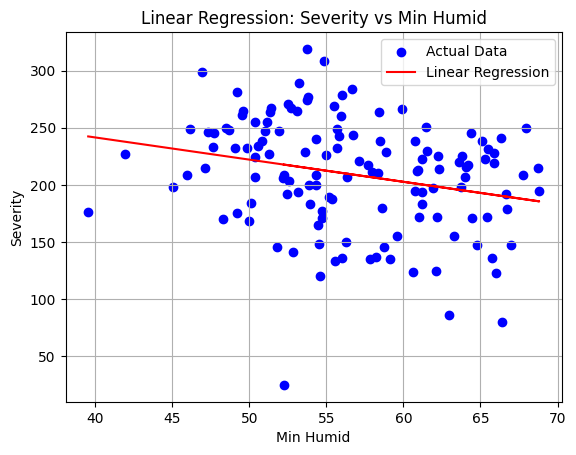

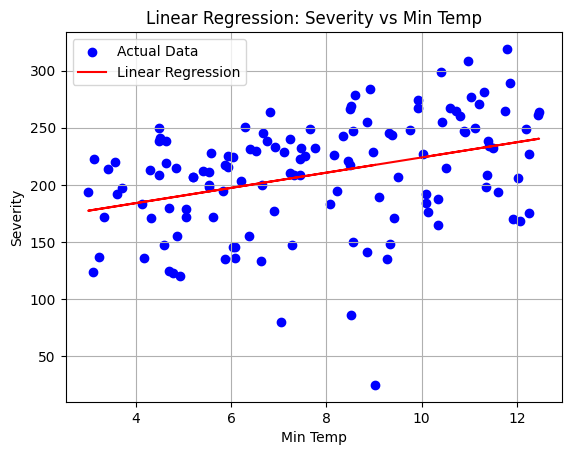

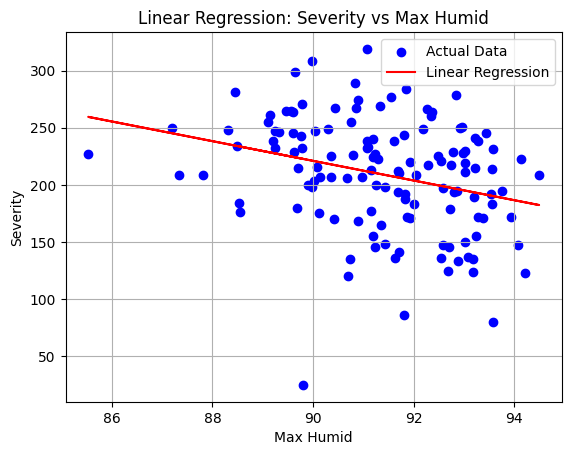

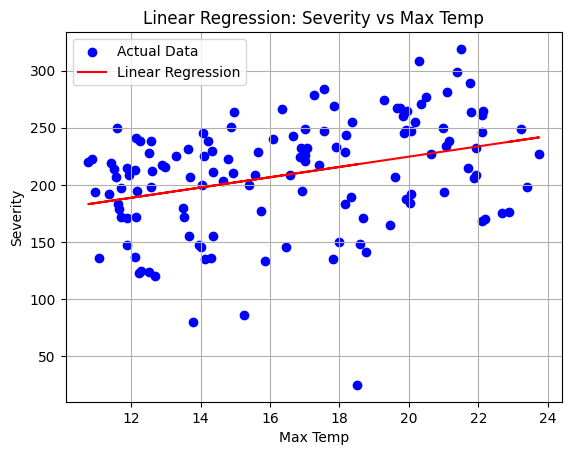

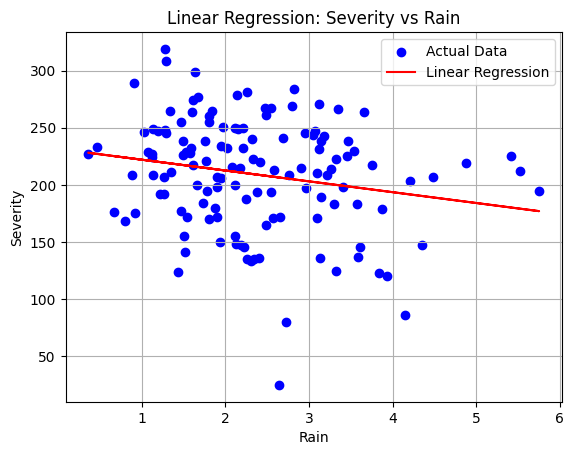

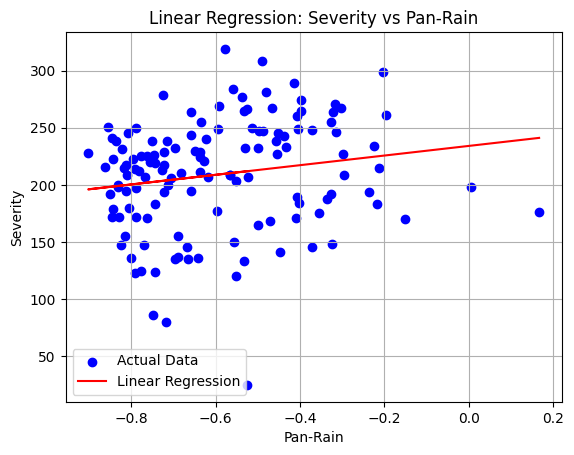

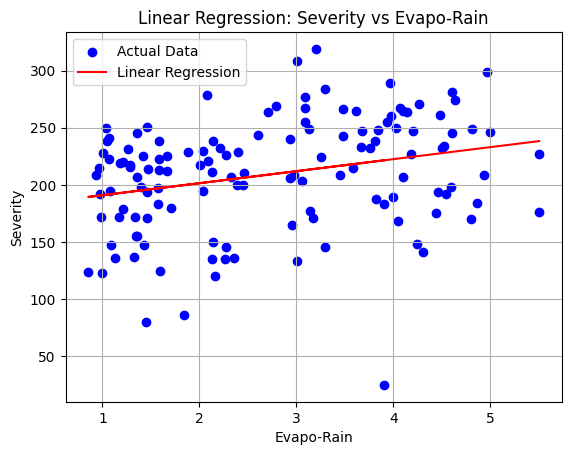

In [56]:
linear_analysis('Min Humid')
linear_analysis('Min Temp')
linear_analysis('Max Humid')
linear_analysis('Max Temp')
linear_analysis('Rain')
linear_analysis('Pan-Rain')
linear_analysis('Evapo-Rain')